In [1]:
# Mount gdrive folders on this colab session
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -r /content/drive/MyDrive/influence-analysis/requirements.txt

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

from keras.losses import BinaryCrossentropy
from keras.utils import to_categorical

from keras import Sequential, layers


from deel.influenciae.common import InfluenceModel, ExactIHVP
from deel.influenciae.influence import FirstOrderInfluenceCalculator
from deel.influenciae.utils import ORDER
from deel.influenciae.trac_in import TracIn
from keras.losses import BinaryCrossentropy

import warnings
# Patch temporanea per compatibilità con numpy >=1.24
if not hasattr(np, 'float'):
    np.float = float
warnings.filterwarnings('ignore')


True


In [5]:
# Load Titanic CSV into DataFrame
train_file_path = '/content/drive/MyDrive/influence-analysis/dataset/titanic.csv'
original_df = pd.read_csv(train_file_path)
original_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
# Copy DataFrame, rename PassengerId to ID, and remove Name, Ticket, Cabin columns
df = original_df.copy()
df.rename(columns={'PassengerId': 'ID'}, inplace=True)
df = df.drop(columns=["Name", "Ticket", "Cabin"])
df


,ID,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [8]:
print(df.isna().sum())

ID            0
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


In [9]:
df = df.dropna(subset=['Embarked'])
df

,ID,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [11]:
# Copy DataFrame, add missing-age indicator, and fill NaN in Age with 0
df = df.copy()
df['MissAge'] = df['Age'].isna().astype(int)
df.fillna({'Age': 0}, inplace=True)
df


,ID,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MissAge
0,1,0,3,male,22.0,1,0,7.2500,S,0
1,2,1,1,female,38.0,1,0,71.2833,C,0
2,3,1,3,female,26.0,0,0,7.9250,S,0
3,4,1,1,female,35.0,1,0,53.1000,S,0
4,5,0,3,male,35.0,0,0,8.0500,S,0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S,0
887,888,1,1,female,19.0,0,0,30.0000,S,0
888,889,0,3,female,0.0,1,2,23.4500,S,0
889,890,1,1,male,26.0,0,0,30.0000,C,0


In [12]:
print(df.isna().sum())

ID          0
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
MissAge     0
dtype: int64


In [13]:
# Encode Sex and Embarked columns as numeric labels
sex_trans = LabelEncoder()
df['Sex'] = sex_trans.fit_transform(df['Sex'])

Emb_trans = LabelEncoder()
df['Embarked'] = Emb_trans.fit_transform(df['Embarked'])

df


,ID,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MissAge
0,1,0,3,1,22.0,1,0,7.2500,2,0
1,2,1,1,0,38.0,1,0,71.2833,0,0
2,3,1,3,0,26.0,0,0,7.9250,2,0
3,4,1,1,0,35.0,1,0,53.1000,2,0
4,5,0,3,1,35.0,0,0,8.0500,2,0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,13.0000,2,0
887,888,1,1,0,19.0,0,0,30.0000,2,0
888,889,0,3,0,0.0,1,2,23.4500,2,0
889,890,1,1,1,26.0,0,0,30.0000,0,0


In [14]:
# Scale Age and Fare with StandardScaler
Normalize = StandardScaler()
Normalize_cols = ["Age", "Fare"]
df[Normalize_cols] = Normalize.fit_transform(df[Normalize_cols])
df


,ID,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MissAge
0,1,0,3,1,-0.099150,1,0,-0.500240,2,0
1,2,1,1,0,0.812389,1,0,0.788947,0,0
2,3,1,3,0,0.128735,0,0,-0.486650,2,0
3,4,1,1,0,0.641476,1,0,0.422861,2,0
4,5,0,3,1,0.641476,0,0,-0.484133,2,0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,0.185706,0,0,-0.384475,2,0
887,888,1,1,0,-0.270063,0,0,-0.042213,2,0
888,889,0,3,0,-1.352516,1,2,-0.174084,2,0
889,890,1,1,1,0.128735,0,0,-0.042213,0,0


In [16]:
# Prepare feature matrix and target: drop Survived, normalize ID, combine features & ID, and one-hot encode labels
X = df.drop(columns=['Survived'])
y = df['Survived']
IDs = X['ID'].values.reshape(-1,1).astype(np.float32)
IDs = IDs / 1e7

X_withNotID = X.drop(columns=['ID']).values.astype(np.float32)
X_withNotID = np.hstack((X_withNotID, IDs))
y_oneHot = to_categorical(y.values, num_classes=2)

X_withNotID.shape


(889, 9)

In [17]:
y_oneHot.shape

(889, 2)

In [18]:
# Split data and IDs into 80/20 train-test sets with a fixed random state
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X_withNotID, y_oneHot, IDs, test_size=0.2, random_state=42
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(711, 9)
(178, 9)
(711, 2)
(178, 2)


In [19]:
# Create TensorFlow Dataset objects for training and testing data
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [20]:
print(len(train_ds))
print(len(test_ds))

711
178


In [24]:
# Define, compile, and train a simple feedforward neural network
model = Sequential([
    layers.Dense(32, activation='relu', input_shape=(9,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds.batch(32),
    epochs=10,
    validation_data=test_ds.batch(32),
    verbose=2
)
#Evaluate model performance on the held-out test set
loss, accuracy = model.evaluate(
    test_ds.batch(32),
    verbose=2
)

Epoch 1/10
23/23 - 1s - loss: 0.6593 - accuracy: 0.6329 - val_loss: 0.6323 - val_accuracy: 0.6348 - 629ms/epoch - 27ms/step
Epoch 2/10
23/23 - 1s - loss: 0.6187 - accuracy: 0.6442 - val_loss: 0.6065 - val_accuracy: 0.6573 - 620ms/epoch - 27ms/step
Epoch 3/10
23/23 - 1s - loss: 0.6006 - accuracy: 0.6596 - val_loss: 0.5918 - val_accuracy: 0.6685 - 807ms/epoch - 35ms/step
Epoch 4/10
23/23 - 1s - loss: 0.5871 - accuracy: 0.6793 - val_loss: 0.5791 - val_accuracy: 0.6854 - 885ms/epoch - 38ms/step
Epoch 5/10
23/23 - 1s - loss: 0.5739 - accuracy: 0.6835 - val_loss: 0.5668 - val_accuracy: 0.7022 - 737ms/epoch - 32ms/step
Epoch 6/10
23/23 - 1s - loss: 0.5606 - accuracy: 0.6962 - val_loss: 0.5547 - val_accuracy: 0.7191 - 583ms/epoch - 25ms/step
Epoch 7/10
23/23 - 1s - loss: 0.5465 - accuracy: 0.7201 - val_loss: 0.5420 - val_accuracy: 0.7360 - 601ms/epoch - 26ms/step
Epoch 8/10
23/23 - 1s - loss: 0.5324 - accuracy: 0.7314 - val_loss: 0.5297 - val_accuracy: 0.7528 - 587ms/epoch - 26ms/step
Epoch 9/

In [26]:
#first order influence
# Configure loss to return individual sample losses (required for influence computation)
unreduced_loss = BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

# Wrap the trained model in an InfluenceModel for downstream influence methods
influence_model = InfluenceModel(model, start_layer=-1, loss_function=unreduced_loss)

# Set up the exact inverse-Hessian-vector-product (IHVP) calculator on a shuffled training set
ihvp_calculator = ExactIHVP(influence_model, train_dataset=train_ds.shuffle(100).batch(32))

# Initialize the first-order influence calculator using the IHVP helper
influence_calculator = FirstOrderInfluenceCalculator(influence_model, train_ds.batch(32), ihvp_calculator)

# Count how many training samples there are (for full-dataset ranking)
num_train_samples = len(train_ds)

# Pick the first 5 test examples and their IDs for explanation
samples_to_explain = test_ds.take(5).batch(1)
ids_to_explain = ids_test[:5]

# Compute the full top-k ranking (k = all train samples) of influences for each selected test sample
explanation_ds = influence_calculator.top_k(samples_to_explain, train_ds.batch(32), k=num_train_samples, order=ORDER.DESCENDING)

fo_results = {}  # Initialize dictionary before loop

# Extract and save the results
for i, ((sample, _), top_k_values, top_k_samples) in enumerate(explanation_ds.as_numpy_iterator()):

    test_id = int(round(ids_to_explain[i][0] * 1e7))
    influential_ids = [int(round(s[-1] * 1e7)) for s in top_k_samples[0]]
    scores = top_k_values[0]

    # Store results in dictionary keyed by test sample ID
    fo_results[test_id] = {'ids': influential_ids, 'scores': scores}
    print(f"Calculated influence for test sample ID: {test_id}")


Calculated influence for test sample ID: 282
Calculated influence for test sample ID: 436
Calculated influence for test sample ID: 40
Calculated influence for test sample ID: 419
Calculated influence for test sample ID: 586


In [27]:
print(int(round(ids_to_explain[0][0] * 1e7)))

282


In [29]:
#Define and compile a simple feedforward neural network
model = Sequential([
    layers.Dense(32, activation='relu', input_shape=(9,)),  # hidden layer with 32 units
    layers.Dense(16, activation='relu'),                    # hidden layer with 16 units
    layers.Dense(2, activation='sigmoid')                   # output layer for 2 classes
])
model.compile(
    optimizer='adam',               # adaptive optimizer
    loss='binary_crossentropy',     # binary cross-entropy loss
    metrics=['accuracy']            # track accuracy metric
)

# 2. Prepare for influence calculations
epochs = 10
unreduced_loss_fn = BinaryCrossentropy(
    from_logits=True,                                # expect raw logits
    reduction=tf.keras.losses.Reduction.NONE         # return loss per sample
)

# 3. Create a list to store InfluenceModel snapshots and add the initial model
model_list = []
model_list.append(InfluenceModel(model, start_layer=-1, loss_function=unreduced_loss_fn))

# 4. Train for one epoch at a time, cloning and storing the model after each epoch
for i in range(epochs):
    model.fit(
        train_ds.batch(32),
        epochs=1,
        validation_data=test_ds.batch(32),
        verbose=2
    )
    # Clone the trained model structure and weights
    updated_model = tf.keras.models.clone_model(model)
    updated_model.set_weights(model.get_weights())
    # Wrap the cloned model in an InfluenceModel and append to the list
    model_list.append(
        InfluenceModel(updated_model, start_layer=-1, loss_function=unreduced_loss_fn)
    )

# 5. Evaluate the final trained model on the test set
model.evaluate(
    test_ds.batch(32),
    verbose=2
)


23/23 - 1s - loss: 0.6754 - accuracy: 0.6343 - val_loss: 0.6564 - val_accuracy: 0.6854 - 755ms/epoch - 33ms/step
23/23 - 1s - loss: 0.6372 - accuracy: 0.6653 - val_loss: 0.6296 - val_accuracy: 0.6854 - 1s/epoch - 47ms/step
23/23 - 1s - loss: 0.6144 - accuracy: 0.6850 - val_loss: 0.6091 - val_accuracy: 0.7022 - 602ms/epoch - 26ms/step
23/23 - 1s - loss: 0.5958 - accuracy: 0.6864 - val_loss: 0.5912 - val_accuracy: 0.7191 - 600ms/epoch - 26ms/step
23/23 - 1s - loss: 0.5777 - accuracy: 0.6906 - val_loss: 0.5736 - val_accuracy: 0.7303 - 782ms/epoch - 34ms/step
23/23 - 1s - loss: 0.5602 - accuracy: 0.7060 - val_loss: 0.5559 - val_accuracy: 0.7360 - 898ms/epoch - 39ms/step
23/23 - 1s - loss: 0.5430 - accuracy: 0.7257 - val_loss: 0.5407 - val_accuracy: 0.7584 - 695ms/epoch - 30ms/step
23/23 - 1s - loss: 0.5271 - accuracy: 0.7370 - val_loss: 0.5277 - val_accuracy: 0.7753 - 614ms/epoch - 27ms/step
23/23 - 1s - loss: 0.5121 - accuracy: 0.7553 - val_loss: 0.5148 - val_accuracy: 0.7978 - 612ms/epoc

[0.50242680311203, 0.8089887499809265]

In [30]:
# 1. Initialize the TracIn influence calculator with the saved model snapshots and a learning rate
influence_calculator = TracIn(model_list, 0.01)
tracin_results = {}

# 2. Define the total number of training samples and select the first 5 test examples
num_train_samples = len(X_train)
samples_to_explain = test_ds.take(5).batch(1)

# 3. Compute the full top-k (k = all train samples) TracIn influence scores for each selected test sample
explanation_ds = influence_calculator.top_k(
    samples_to_explain,
    train_ds.batch(32),
    k=num_train_samples,
    order=ORDER.DESCENDING
)

# 4. Iterate over the results, recover IDs and scores, and store them
tracin_results = {}
for i, ((sample, _), top_k_values, top_k_samples) in enumerate(explanation_ds.as_numpy_iterator()):
    # a) Recover the original test sample ID by scaling back the normalized value
    test_id = int(round(ids_to_explain[i][0] * 1e7))
    # b) Extract the top‐k training sample IDs from the last feature column and rescale
    influential_ids = [int(round(s[-1] * 1e7)) for s in top_k_samples[0]]
    # c) Get the corresponding TracIn scores
    scores = top_k_values[0]
    # d) Save to dictionary keyed by test sample ID
    tracin_results[test_id] = {'ids': influential_ids, 'scores': scores}
    print(f"Calculated influence for test sample ID: {test_id}")


Calculated influence for test sample ID: 282
Calculated influence for test sample ID: 436
Calculated influence for test sample ID: 40
Calculated influence for test sample ID: 419
Calculated influence for test sample ID: 586


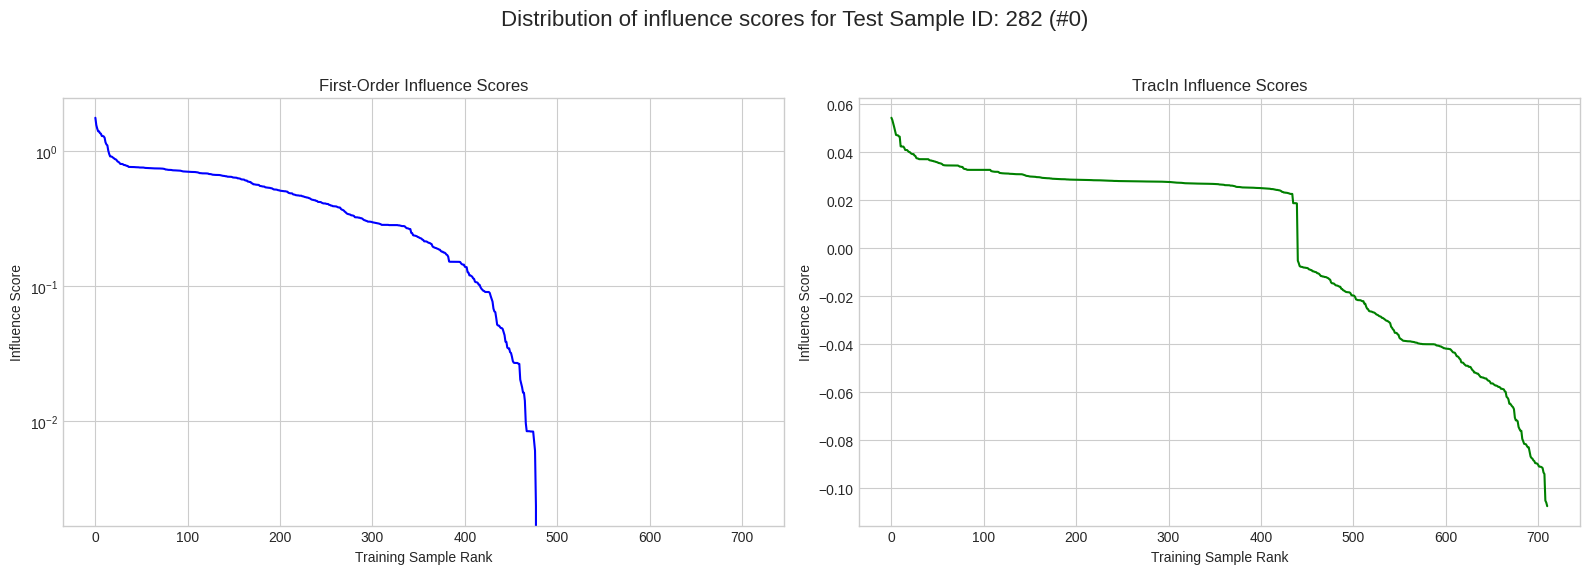

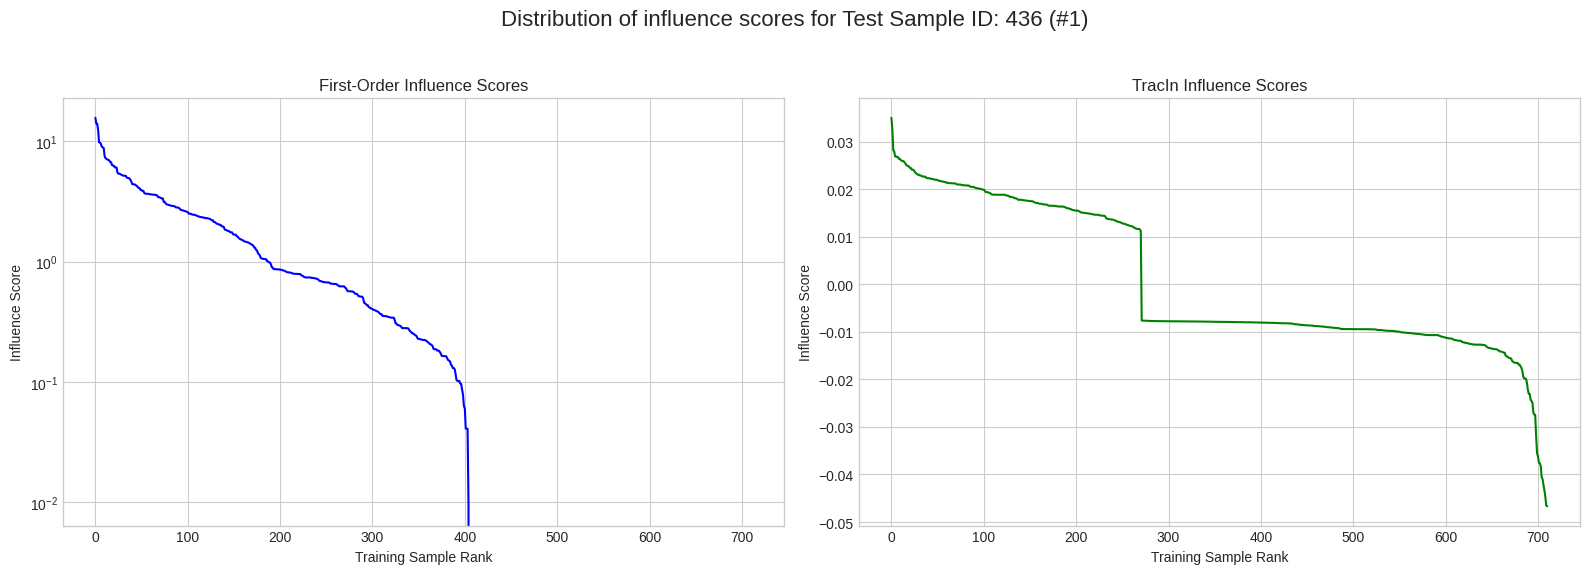

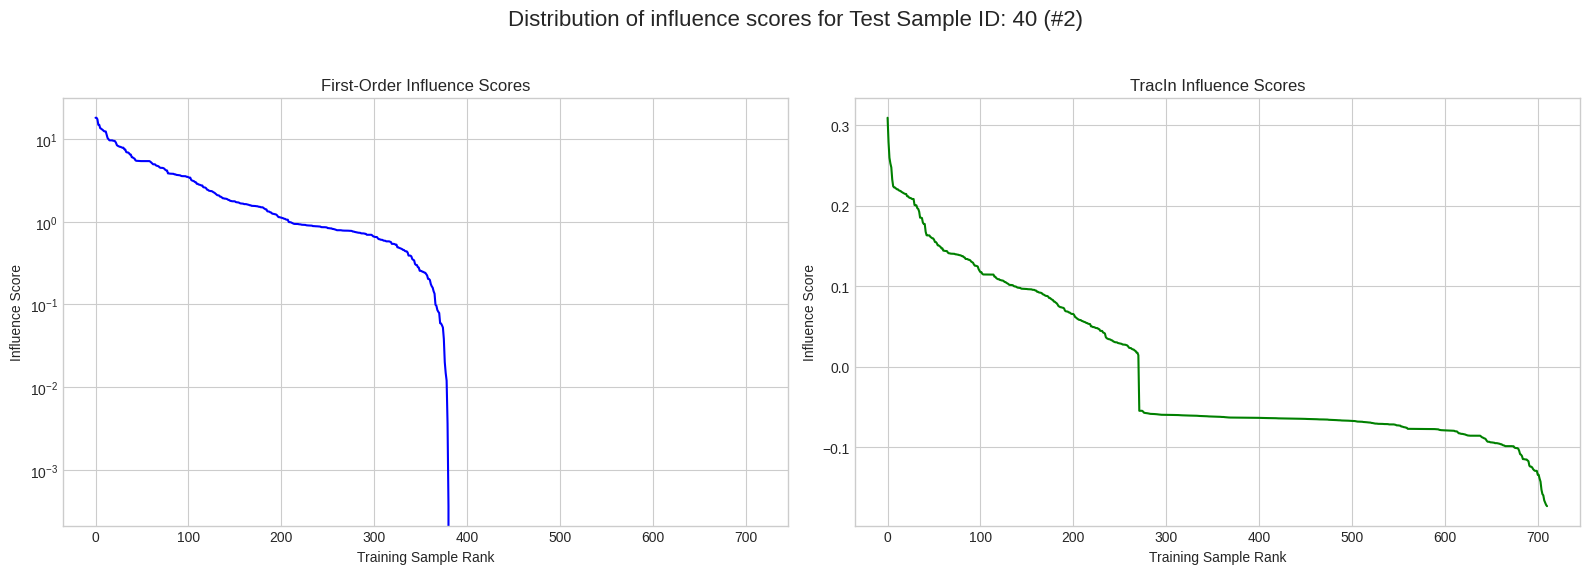

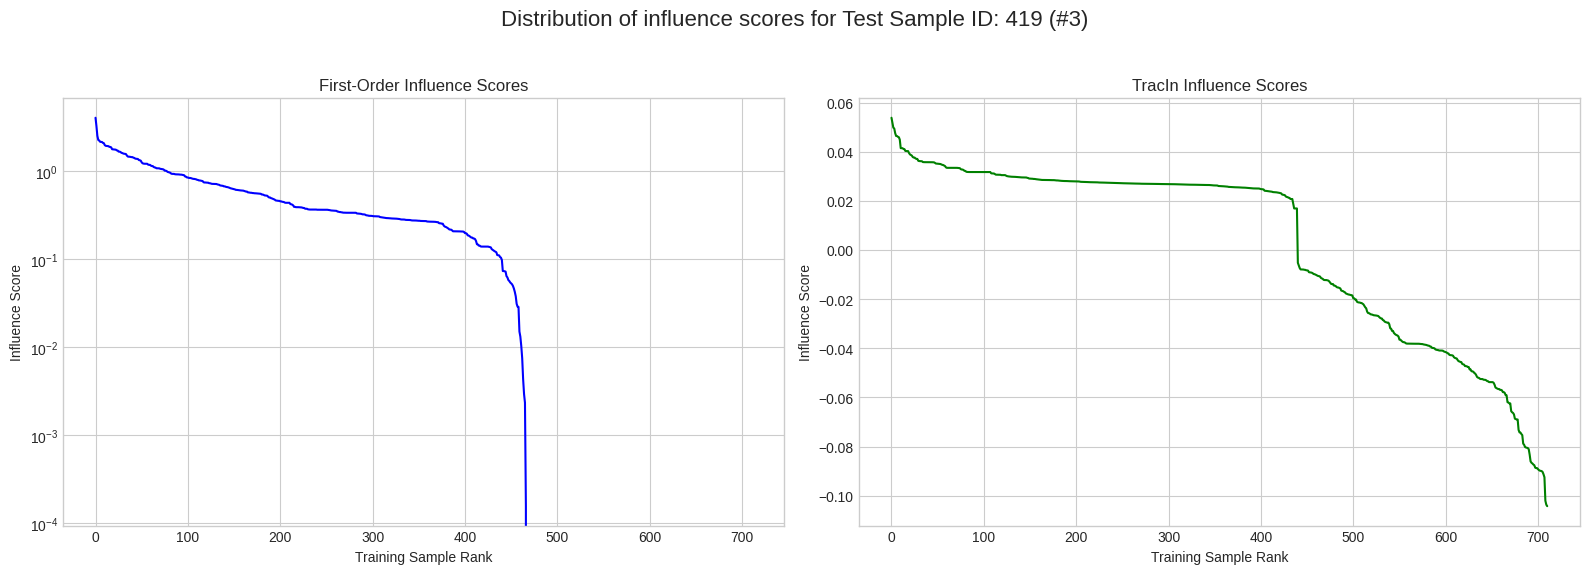

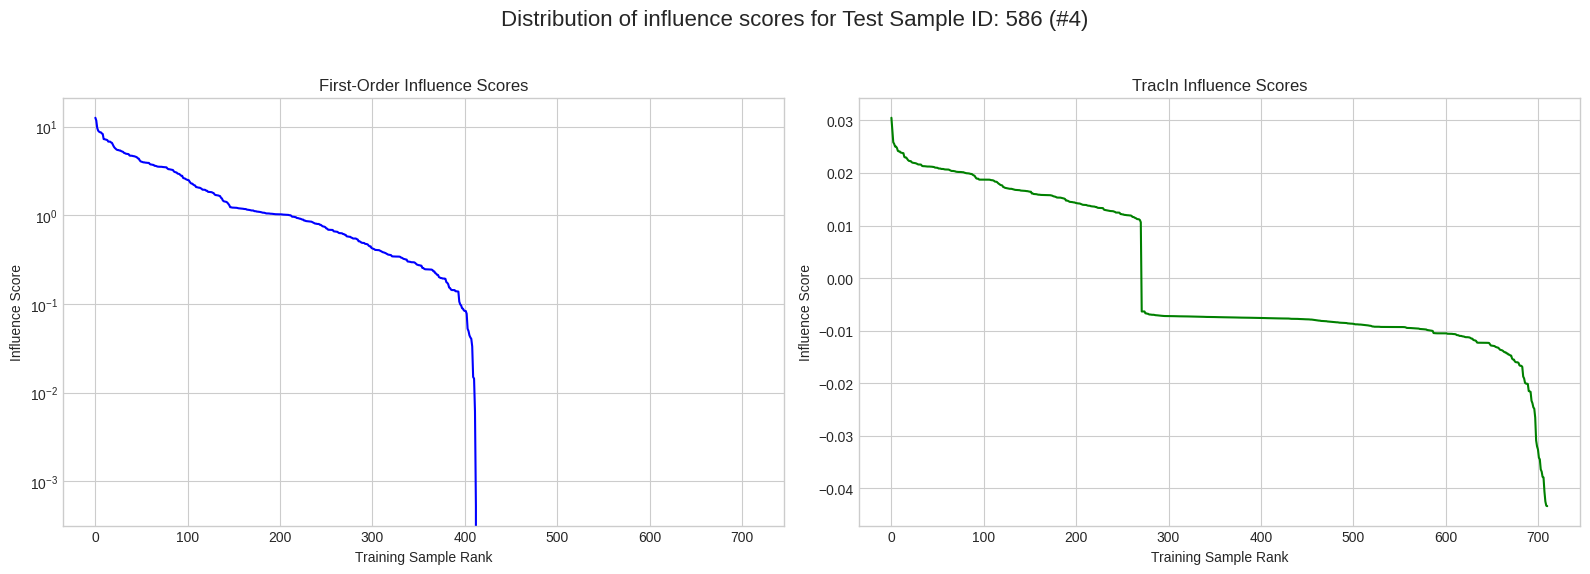

In [31]:
plt.style.use('seaborn-v0_8-whitegrid')

for i, sample_id_to_plot in enumerate(list(fo_results.keys())[:5]):
    fo_scores = fo_results[sample_id_to_plot]['scores']
    tracin_scores = tracin_results[sample_id_to_plot]['scores']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(
        f'Distribution of influence scores for Test Sample ID: {sample_id_to_plot} (#{i})',
        fontsize=16
    )

    # First-Order plot
    ax1.plot(range(len(fo_scores)), fo_scores, color='blue')
    ax1.set_title('First-Order Influence Scores')
    ax1.set_xlabel('Training Sample Rank')
    ax1.set_ylabel('Influence Score')
    ax1.set_yscale('log')

    # TracIn plot
    ax2.plot(range(len(tracin_scores)), tracin_scores, color='green')
    ax2.set_title('TracIn Influence Scores')
    ax2.set_xlabel('Training Sample Rank')
    ax2.set_ylabel('Influence Score')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [44]:
# 1. Initialize a list to collect consistency metrics for each test sample
consistency_scores = []

# 2. Loop over each test sample ID in the First-Order results
for test_id in fo_results.keys():
    # 2a. Get the top-k training IDs for both methods
    fo_ranked_ids     = fo_results[test_id]['ids']
    tracin_ranked_ids = tracin_results[test_id]['ids']

    # 2b. Build lookup tables mapping each training ID to its rank
    fo_rank_map     = {id_val: rank for rank, id_val in enumerate(fo_ranked_ids)}
    tracin_rank_map = {id_val: rank for rank, id_val in enumerate(tracin_ranked_ids)}

    # 3. Combine IDs from both methods to ensure a common universe
    all_ids = sorted(set(fo_ranked_ids) | set(tracin_ranked_ids))

    # 4. Create two parallel rank lists (missing IDs get rank=len(all_ids))
    rank_list_1 = [fo_rank_map.get(id_val, len(all_ids))     for id_val in all_ids]
    rank_list_2 = [tracin_rank_map.get(id_val, len(all_ids)) for id_val in all_ids]

    # 5. Compute Kendall’s Tau correlation and its p-value
    tau, p_value = kendalltau(rank_list_1, rank_list_2)

    # 6. Store the results for this test ID
    consistency_scores.append({
        'Test ID':    test_id,
        'Kendall Tau': tau,
        'p-value':     p_value
    })

# 7. Convert the collected metrics into a pandas DataFrame
consistency_df = pd.DataFrame(consistency_scores)

# 8. Output a header and display the consistency table
print("--- Consistency between First-Order and TracIn ---")
print(consistency_df)


--- Consistency between First-Order and TracIn ---
   Test ID  Kendall Tau       p-value
0      282     0.196102  5.109520e-15
1      436     0.244643  1.656652e-22
2       40     0.395527  4.204991e-56
3      419     0.139526  2.593258e-08
4      586     0.206775  1.583452e-16


In [39]:
k = 5

for idx in range(k):
    test_id_to_inspect = list(fo_results.keys())[idx]

    # Extract top K IDs for each method
    fo_top_ids = fo_results[test_id_to_inspect]['ids'][:k]
    tracin_top_ids = tracin_results[test_id_to_inspect]['ids'][:k]

    # Inspection details
    print(f"Inspecting test sample ID: {test_id_to_inspect}")

    # Influence rankings
    print(f"Top 5 most influential samples by First-Order: {fo_top_ids}")
    print(f"Top 5 most influential samples by TracIn:      {tracin_top_ids}")


    print("---------------")

Inspecting test sample ID: 282
Top 5 most influential samples by First-Order: [648, 727, 168, 670, 14]
Top 5 most influential samples by TracIn:      [439, 639, 679, 568, 594]
---------------
Inspecting test sample ID: 436
Top 5 most influential samples by First-Order: [551, 803, 306, 391, 764]
Top 5 most influential samples by TracIn:      [262, 234, 623, 302, 470]
---------------
Inspecting test sample ID: 40
Top 5 most influential samples by First-Order: [710, 66, 623, 645, 470]
Top 5 most influential samples by TracIn:      [262, 302, 665, 126, 234]
---------------
Inspecting test sample ID: 419
Top 5 most influential samples by First-Order: [631, 660, 12, 103, 150]
Top 5 most influential samples by TracIn:      [439, 639, 679, 568, 594]
---------------
Inspecting test sample ID: 586
Top 5 most influential samples by First-Order: [551, 391, 803, 670, 764]
Top 5 most influential samples by TracIn:      [262, 234, 302, 623, 710]
---------------


In [43]:
k_to_remove = 20
test_id_for_removal = list(fo_results.keys())[0]

# Take the top-k IDs to remove according to TracIn
ids_to_remove = tracin_results[test_id_for_removal]['ids'][:k_to_remove]
ids_to_remove_set = set(ids_to_remove)

print(f"--- Removal Experiment: {k_to_remove} most influential samples according to TracIn ---")
print(f"ORIGINAL model performance: Accuracy = {accuracy:.4f}, Loss = {loss:.4f}")

# Create a new training set excluding the IDs to remove
mask_to_keep = [int(id_val[0]) not in ids_to_remove_set for id_val in ids_train]
X_train_purged = X_train[mask_to_keep]
y_train_purged = y_train[mask_to_keep]

print(f"Original Training Set Size: {len(X_train)}")
print(f"New Training Set Size: {len(X_train_purged)}")

# Build and train a new model on the purged dataset
model = Sequential([
    layers.Dense(32, activation='relu', input_shape=(9,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_ds.batch(32),
    epochs=10,
    validation_data=test_ds.batch(32),
    verbose=2
)

loss_new, accuracy_new = model.evaluate(
    test_ds.batch(32),
    verbose=2
)

print(f"RETRAINED model performance: Accuracy = {accuracy_new:.4f}, Loss = {loss_new:.4f}")

# Compare performances
accuracy_drop = accuracy - accuracy_new
loss_increase = loss_new - loss
print(f"\nAccuracy Drop: {accuracy_drop:.4f}")
print(f"Loss Increase: {loss_increase:.4f}")

--- Removal Experiment: 20 most influential samples according to TracIn ---
ORIGINAL model performance: Accuracy = 0.7978, Loss = 0.5068
Original Training Set Size: 711
New Training Set Size: 711
Epoch 1/10
23/23 - 1s - loss: 0.6604 - accuracy: 0.6231 - val_loss: 0.6418 - val_accuracy: 0.6124 - 976ms/epoch - 42ms/step
Epoch 2/10
23/23 - 1s - loss: 0.6382 - accuracy: 0.6259 - val_loss: 0.6239 - val_accuracy: 0.6011 - 668ms/epoch - 29ms/step
Epoch 3/10
23/23 - 1s - loss: 0.6242 - accuracy: 0.6371 - val_loss: 0.6095 - val_accuracy: 0.6348 - 610ms/epoch - 27ms/step
Epoch 4/10
23/23 - 1s - loss: 0.6118 - accuracy: 0.6568 - val_loss: 0.5964 - val_accuracy: 0.6629 - 588ms/epoch - 26ms/step
Epoch 5/10
23/23 - 1s - loss: 0.5998 - accuracy: 0.6709 - val_loss: 0.5847 - val_accuracy: 0.7022 - 599ms/epoch - 26ms/step
Epoch 6/10
23/23 - 1s - loss: 0.5881 - accuracy: 0.6878 - val_loss: 0.5744 - val_accuracy: 0.7135 - 601ms/epoch - 26ms/step
Epoch 7/10
23/23 - 1s - loss: 0.5771 - accuracy: 0.7004 - va